In [1]:
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
from datetime import date
from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import skew
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from scipy import stats
import utility
from scipy import stats

In [2]:
# from sklearn.datasets import make_regression
# from sklearn.model_selection import cross_validate
# from xgboost import XGBClassifier
# from sklearn.metrics import roc_auc_score, make_scorer

# def cus_scoring(y_pred, y_act):
#     score=stats.pearsonr(y_pred, y_act)[0]
#     return score

# X, y = make_regression(n_samples=200, n_features=3, noise=0.2)

# model = XGBRegressor(scale_pos_weight=9)

# scoring = {'mae' : 'neg_mean_absolute_error','mse':'neg_mean_squared_error','r square':'r2','Pearson':make_scorer(cus_scoring, greater_is_better=True)}

# # scores = cross_validate(model, X, y, scoring=make_scorer(cus_scoring, greater_is_better=True), cv=3, n_jobs=-1)
# scores = cross_validate(model, X, y, scoring=scoring, cv=3, n_jobs=-1)

# Zomato

In [3]:
# zomato only
df_zom = pd.read_csv('data/3_clean_zomato_feat_ori_train.csv')
# df_zom = pd.read_csv('data/3_jbdk_clean_zomato_feat.csv')

df_zom['rest_price_idr'] = df_zom['rest_price_idr'] / 1000
df_zom['rest_price_idr'] = df_zom['rest_price_idr'].astype(int)

# encode 
# drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac']

# ori 
drop_column = ['url','index','rating','lat','long','review']
target_column = 'rating'


# cross validation 

rf_param = {'n_estimators':500,'max_features':3, 'max_depth':30,'bootstrap':True}
xgb_param = {'n_estimators':100, 'max_depth':5, 'min_child_weight':3, 'learning_rate':0.15, 'booster':'gbtree'}
svr_param  = {'kernel':'poly','gamma':0.1,'C':0.1}


result_zomato_loop, result_zomato = utility.bulk_train_k_fold(df_input=df_zom, drop_column=drop_column, target_column=target_column, dataset_name='zomato_only', rf_param = rf_param, xgb_param=xgb_param, svr_param=svr_param)
result_zomato_loop['test_neg_mean_squared_error']= result_zomato_loop['test_neg_mean_squared_error']*-1
result_zomato_loop['test_neg_mean_absolute_error']= result_zomato_loop['test_neg_mean_absolute_error']*-1
result_zomato_loop['feature_size'] = len(df_zom.drop(drop_column, axis=1).columns)
result_zomato_loop['record'] = df_zom.drop(drop_column, axis=1).shape[0]
result_zomato_loop = result_zomato_loop.reset_index()

# Zomato 250 

In [6]:
# zomato geo 250
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_ori_250_train.csv')
# df_zom_poi = pd.read_csv('data/3_jbdk_clean_zomato_gof_250.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

# encode 
# drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']

# ori
drop_column = ['url','index','rating','lat','long','review','geohash','encode']

target_column = 'rating'

# cross validation
rf_param = {'n_estimators':250,'max_features':3, 'max_depth':30,'bootstrap':True}
xgb_param = {'n_estimators':100, 'max_depth':5, 'min_child_weight':1, 'learning_rate':0.15, 'booster':'gbtree'}
svr_param  = {'kernel':'poly','gamma':0.1,'C':0.1}

result_zomato_250_loop,  result_zomato_250  = utility.bulk_train_k_fold(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_poi_250',rf_param = rf_param, xgb_param=xgb_param, svr_param=svr_param)
result_zomato_250_loop['test_neg_mean_squared_error'] = result_zomato_250_loop['test_neg_mean_squared_error']*-1
result_zomato_250_loop['test_neg_mean_absolute_error'] = result_zomato_250_loop['test_neg_mean_absolute_error']*-1
result_zomato_250_loop['feature_size'] = len(df_zom_poi.drop(drop_column, axis=1).columns)
result_zomato_250_loop['record'] = df_zom_poi.drop(drop_column, axis=1).shape[0]

result_zomato_250_loop = result_zomato_250_loop.reset_index()

# Zomato 500 

In [7]:
# zomato geo 500
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_ori_500_train.csv')
# df_zom_poi = pd.read_csv('data/3_jbdk_clean_zomato_gof_500.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)


# encode 
# drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']

# ori
drop_column = ['url','index','rating','lat','long','review','geohash','encode']

# cross validation
rf_param = {'n_estimators':500,'max_features':3, 'max_depth':30,'bootstrap':True}
xgb_param = {'n_estimators':100, 'max_depth':5, 'min_child_weight':3, 'learning_rate':0.2, 'booster':'gbtree'}
svr_param  = {'kernel':'poly','gamma':0.1,'C':0.1}

result_zomato_500_loop,  result_zomato_500 = utility.bulk_train_k_fold(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_poi_500', rf_param = rf_param, xgb_param=xgb_param, svr_param=svr_param)
result_zomato_500_loop['test_neg_mean_squared_error'] = result_zomato_500_loop['test_neg_mean_squared_error']*-1
result_zomato_500_loop['test_neg_mean_absolute_error'] = result_zomato_500_loop['test_neg_mean_absolute_error']*-1
result_zomato_500_loop['feature_size'] = len(df_zom_poi.drop(drop_column, axis=1).columns)
result_zomato_500_loop['record'] = df_zom_poi.drop(drop_column, axis=1).shape[0]

result_zomato_500_loop = result_zomato_500_loop.reset_index()

# Zomato 1000

In [10]:
# zomato geo 1000
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_ori_1000_train.csv')
# df_zom_poi = pd.read_csv('data/3_jbdk_clean_zomato_gof_1000.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

# encode 
# drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']

# ori
drop_column = ['url','index','rating','lat','long','review','geohash','encode']
target_column = 'rating'

# cross validation
rf_param = {'n_estimators':250,'max_features':3, 'max_depth':250,'bootstrap':True}
xgb_param = {'n_estimators':1100, 'max_depth':2, 'min_child_weight':1, 'learning_rate':0.05, 'booster':'gbtree'}
svr_param  = {'kernel':'poly','gamma':0.1,'C':100}


result_zomato_1000_loop,  result_zomato_1000 = utility.bulk_train_k_fold(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_poi_1000',rf_param = rf_param, xgb_param=xgb_param, svr_param=svr_param)
result_zomato_1000_loop['test_neg_mean_squared_error'] = result_zomato_1000_loop['test_neg_mean_squared_error']*-1
result_zomato_1000_loop['test_neg_mean_absolute_error'] = result_zomato_1000_loop['test_neg_mean_absolute_error']*-1
result_zomato_1000_loop['feature_size'] = len(df_zom_poi.drop(drop_column, axis=1).columns)
result_zomato_1000_loop['record'] = df_zom_poi.drop(drop_column, axis=1).shape[0]


result_zomato_1000_loop = result_zomato_1000_loop.reset_index()

In [11]:
# cross validation 
df_total_result = pd.concat([result_zomato_loop,result_zomato_250_loop, result_zomato_500_loop, result_zomato_1000_loop])

# train and test 
df_total_normal = pd.concat([result_zomato , result_zomato_250, result_zomato_500, result_zomato_1000])

In [12]:
df_total_normal

,mae,mse,pearson,name,dataset,feature_size,train_size,test_size
0,0.120950,0.024620,0.446060,rf,zomato_only,41,4162,568
1,0.120432,0.023941,0.459246,xgb,zomato_only,41,4162,568
2,0.123379,0.025370,0.408418,svr,zomato_only,41,4162,568
0,0.124353,0.025554,0.395466,rf,zomato_poi_250,60,4162,568
1,0.123189,0.025043,0.421007,xgb,zomato_poi_250,60,4162,568
2,0.123328,0.025216,0.413114,svr,zomato_poi_250,60,4162,568
0,0.123003,0.024900,0.423666,rf,zomato_poi_500,60,4162,568
1,0.125702,0.025923,0.401123,xgb,zomato_poi_500,60,4162,568
2,0.122551,0.025089,0.420049,svr,zomato_poi_500,60,4162,568
0,0.122954,0.024566,0.437062,rf,zomato_poi_1000,60,4162,568


In [13]:
today = date.today()
print("Today's date:", today)

Today's date: 2022-11-23


In [14]:
df_total_result.to_excel('report/ml_perform_crossval_raw_{}.xlsx'.format(today),index=False)
df_total_normal.to_excel('report/ml_perform_normal_{}.xlsx'.format(today),index=False)

In [15]:
df_zom_poi.drop(drop_column, axis=1).columns

Index(['rest_price_idr', 'is_chain', 'alcohol', 'delivery', 'entertainment',
       'indoor seating', 'kid friendly', 'no alcohol available',
       'others_facility', 'outdoor seating', 'parking service', 'praying room',
       'private dining area available', 'self service', 'smoking area',
       'special_meal', 'table booking', 'table booking not available',
       'table reservation required', 'takeaway available', 'asian', 'bakery',
       'beverages', 'cafe', 'coffee', 'desserts', 'drink', 'fast_food',
       'india', 'indonesia_traditional', 'indonesian', 'melayu', 'mid_east',
       'noodle', 'others_type', 'seafood', 'snacks', 'special_food',
       'street_food', 'tea', 'western', 'd_1000_airport', 'd_1000_atm',
       'd_1000_bank', 'd_1000_cafe', 'd_1000_convenience_store',
       'd_1000_gas_station', 'd_1000_hospital', 'd_1000_lodging',
       'd_1000_meal_takeaway', 'd_1000_mosque', 'd_1000_park',
       'd_1000_restaurant', 'd_1000_school', 'd_1000_store',
       'd_10

In [16]:
df_total_result.head()

,index,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2,test_Pearson,train_Pearson,name,dataset,feature_size,record
0,0,2.014641,0.097740,0.119960,-0.060290,0.023981,-0.006639,0.194450,0.773187,0.451922,0.901315,rf,zomato_only,41,4731
1,1,1.942717,0.255568,0.124046,-0.059568,0.024349,-0.006582,0.166212,0.776265,0.419463,0.902153,rf,zomato_only,41,4731
2,2,1.985940,0.102759,0.123105,-0.059747,0.024282,-0.006606,0.120169,0.778309,0.404751,0.903550,rf,zomato_only,41,4731
3,3,1.969505,0.104719,0.127872,-0.058545,0.026503,-0.006315,0.138467,0.782348,0.399450,0.905623,rf,zomato_only,41,4731
4,4,2.113609,0.112031,0.122403,-0.059150,0.024498,-0.006343,0.165915,0.784073,0.422286,0.907121,rf,zomato_only,41,4731


# Aggregate report 

In [21]:
df_total_result_agg = df_total_result.groupby(['name','dataset','feature_size']).agg({'test_neg_mean_absolute_error':['mean','std','median','var'],'test_neg_mean_squared_error':['mean','std','median','var'],'test_Pearson':['mean','std','median','var']}).reset_index()
df_total_result_agg.columns = ['name','dataset','feature_size','avg_mae','std_mae','med_mae','var_mae','avg_mse','std_mse','med_mse','var_mse','avg_pearson','std_pearson','med_pearson','var_pearson']

df_total_result_agg.to_excel('report/ml_perform_crossval_agg_{}.xlsx'.format(today),index=False)

In [20]:
df_total_result_agg

,name,dataset,feature_size,avg_mae,std_mae,med_mae,var_mae,avg_mse,std_mse,med_mse,var_mse,avg_pearson,std_pearson,med_pearson,var_pearson
0,rf,zomato_only,41,0.123477,0.002886,0.123105,0.000008,0.024723,0.001013,0.024349,1.025751e-06,0.419575,0.020484,0.419463,0.000420
1,rf,zomato_poi_1000,60,0.123018,0.002628,0.122509,0.000007,0.023758,0.001083,0.023624,1.172063e-06,0.440498,0.018525,0.442723,0.000343
2,rf,zomato_poi_250,60,0.123013,0.003888,0.122974,0.000015,0.023837,0.001330,0.023660,1.769148e-06,0.436047,0.028356,0.444025,0.000804
3,rf,zomato_poi_500,60,0.122072,0.002603,0.121829,0.000007,0.023449,0.001155,0.023376,1.334395e-06,0.456694,0.019900,0.463250,0.000396
4,svr,zomato_only,41,0.124468,0.003953,0.124427,0.000016,0.024523,0.001488,0.024400,2.215336e-06,0.408521,0.023707,0.420445,0.000562
5,svr,zomato_poi_1000,60,0.171424,0.004380,0.173516,0.000019,0.049309,0.003125,0.050855,9.767937e-06,0.253898,0.020437,0.257347,0.000418
6,svr,zomato_poi_250,60,0.124141,0.003941,0.124138,0.000016,0.024329,0.001556,0.024270,2.422321e-06,0.416096,0.026995,0.423279,0.000729
7,svr,zomato_poi_500,60,0.123447,0.004006,0.123265,0.000016,0.024290,0.001534,0.024081,2.353549e-06,0.417491,0.028243,0.427389,0.000798
8,xgb,zomato_only,41,0.121117,0.003133,0.120350,0.000010,0.023599,0.001290,0.023210,1.664505e-06,0.449127,0.024816,0.461639,0.000616
9,xgb,zomato_poi_1000,60,0.122445,0.002543,0.122128,0.000006,0.023721,0.001317,0.023208,1.734856e-06,0.442061,0.024274,0.439777,0.000589


<AxesSubplot:title={'center':'Quality'}>

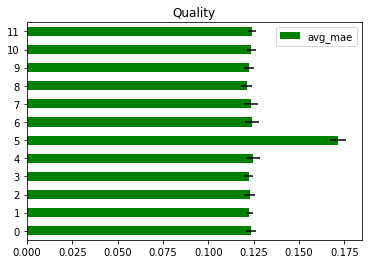

In [18]:
df_total_result_agg.plot(kind = "barh", y = "avg_mae", legend = True, xerr = "std_mae", title = "Quality", color='green')